# Game Success Classification - Steam Games Dataset

## Objective
Predict if a game will be "well-received" based on features using a weighted score:
- Calculate weighted score: `(pct_pos_total / 100.0) × log10(num_reviews_total + 1)`
- Create binary labels (well-received vs not)
- Train Logistic Regression model
- Evaluate model performance

## Dataset
- **Input:** `archive1/train_ml_ready.parquet` and `archive1/test_ml_ready.parquet`
- **Output:** Classification model and evaluation metrics


In [70]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10



In [71]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, log10, mean as spark_mean, udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GameSuccessClassification") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session created")


Spark session created


## Step 1: Load ML-Ready Data


In [ ]:
# Load train and test datasets
train_df = spark.read.parquet("archive1/train_ml_ready.parquet")
test_df = spark.read.parquet("archive1/test_ml_ready.parquet")

print(f"Training set: {train_df.count():,} samples")
print(f"Test set: {test_df.count():,} samples")
print(f"Total columns: {len(train_df.columns)}")


Training set: 9,576 samples
Test set: 2,313 samples
Total columns: 25


## Step 2: Calculate Weighted Score

Calculate the weighted score using:
`weighted_score = (pct_pos_total / 100.0) × log10(num_reviews_total + 1)`


In [73]:
# Calculate weighted score for training data
train_df = train_df.withColumn(
    "weighted_score",
    (col("pct_pos_total") / 100.0) * log10(col("num_reviews_total") + 1)
)

# Calculate weighted score for test data
test_df = test_df.withColumn(
    "weighted_score",
    (col("pct_pos_total") / 100.0) * log10(col("num_reviews_total") + 1)
)

print("Weighted score calculated")
print("\nSample weighted scores:")
train_df.select("name", "pct_pos_total", "num_reviews_total", "weighted_score").show(10, truncate=False)


Weighted score calculated

Sample weighted scores:
+------------------------------------+-------------+-----------------+------------------+
|name                                |pct_pos_total|num_reviews_total|weighted_score    |
+------------------------------------+-------------+-----------------+------------------+
|Team Fortress Classic               |86           |6482             |3.2781273785784975|
|Counter-Strike: Source              |96           |124438           |4.891158251934362 |
|Half-Life 2: Deathmatch             |90           |9455             |3.578136717183462 |
|Half-Life Deathmatch: Source        |73           |3822             |2.6151551375538906|
|Team Fortress 2                     |89           |1146642          |5.392891119469697 |
|Counter-Strike 2                    |86           |8632939          |5.965096501368335 |
|DOOM + DOOM II                      |96           |20821            |4.145781544455606 |
|Vampire: The Masquerade - Bloodlines|94         

## Step 3: Analyze Weighted Score Distribution


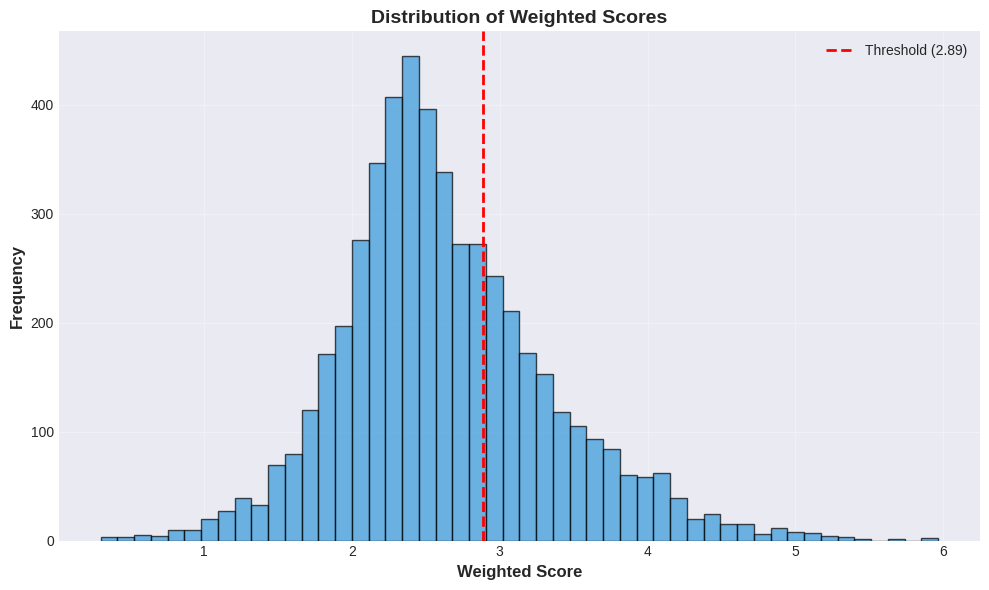

In [88]:
# Visualize weighted score distribution

sample_size = min(5000, train_df.count())
weighted_scores_pd = train_df.select("weighted_score").sample(False, sample_size/train_df.count(), seed=42).toPandas()

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(weighted_scores_pd['weighted_score'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')

# Add threshold line if it's already defined (from running later cells)
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
ax.legend()


ax.set_xlabel('Weighted Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Weighted Scores', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Step 4: Create Binary Labels

Create binary labels: 1 = well-received, 0 = not well-received

**Approach**: Use exact 70th percentile as threshold (top 30% are well-received)


In [89]:
# Calculate 70th percentile threshold from training data

# Use approxQuantile with very small error (0.01 = 1% error) - accurate and no window warnings
threshold = train_df.approxQuantile("weighted_score", [0.7], 0.01)[0]
print(f"70th percentile threshold: {threshold:.4f}")

# Verify the split
total_count = train_df.count()
above_threshold = train_df.filter(col("weighted_score") >= threshold).count()
below_threshold = train_df.filter(col("weighted_score") < threshold).count()

print(f"\nTraining set - Total games: {total_count:,}")
print(f"Games >= threshold (top 30%): {above_threshold:,} ({above_threshold/total_count*100:.1f}%)")
print(f"Games < threshold (bottom 70%): {below_threshold:,} ({below_threshold/total_count*100:.1f}%)")

# Create binary labels using the threshold
train_df = train_df.withColumn(
    "is_well_received",
    when(col("weighted_score") >= threshold, 1).otherwise(0).cast("int")
)

# Apply same threshold to test set
test_df = test_df.withColumn(
    "is_well_received",
    when(col("weighted_score") >= threshold, 1).otherwise(0).cast("int")
)


# Check class distribution
print("\nTraining set:")
train_dist = train_df.groupBy("is_well_received").count().orderBy("is_well_received")
train_dist.show()

train_counts = train_df.groupBy("is_well_received").count().collect()
total_train = train_df.count()
for row in train_counts:
    label = "Well-received" if row.is_well_received == 1 else "Not well-received"
    pct = (row["count"] / total_train) * 100
    print(f"  {label}: {row['count']:,} ({pct:.1f}%)")

print("\nTest set:")
test_dist = test_df.groupBy("is_well_received").count().orderBy("is_well_received")
test_dist.show()

test_counts = test_df.groupBy("is_well_received").count().collect()
total_test = test_df.count()
for row in test_counts:
    label = "Well-received" if row.is_well_received == 1 else "Not well-received"
    pct = (row["count"] / total_test) * 100
    print(f"  {label}: {row['count']:,} ({pct:.1f}%)")


70th percentile threshold: 2.8897

Training set - Total games: 9,576
Games >= threshold (top 30%): 2,968 (31.0%)
Games < threshold (bottom 70%): 6,608 (69.0%)

Training set:
+----------------+-----+
|is_well_received|count|
+----------------+-----+
|               0| 6608|
|               1| 2968|
+----------------+-----+

  Well-received: 2,968 (31.0%)
  Not well-received: 6,608 (69.0%)

Test set:
+----------------+-----+
|is_well_received|count|
+----------------+-----+
|               0| 1607|
|               1|  706|
+----------------+-----+

  Well-received: 706 (30.5%)
  Not well-received: 1,607 (69.5%)


## Step 6: Train Logistic Regression Model


Train and evaluate Logistic Regression model


In [ ]:
# Train Logistic Regression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="is_well_received",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.1
)

lr_model = lr.fit(train_df)

# Make predictions on test set
predictions = lr_model.transform(test_df)

# evaluators
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="is_well_received",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="is_well_received",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="is_well_received",
    predictionCol="prediction",
    metricName="f1"
)

evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="is_well_received",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="is_well_received",
    predictionCol="prediction",
    metricName="weightedRecall"
)

# Evaluate model
auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_acc.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)


print(f"AUC-ROC:        {auc:.4f}")
print(f"Accuracy:       {accuracy:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")

# Show sample predictions

print("SAMPLE PREDICTIONS")

predictions.select("name", "is_well_received", "prediction", "probability").show(10, truncate=False)


Logistic Regression model trained
AUC-ROC:        0.9222
Accuracy:       0.8478
F1-Score:       0.8472
Precision:       0.8467
Recall:          0.8478
SAMPLE PREDICTIONS
+--------------------------------+----------------+----------+----------------------------------------+
|name                            |is_well_received|prediction|probability                             |
+--------------------------------+----------------+----------+----------------------------------------+
|Day of Defeat: Source           |1               |1.0       |[0.18728840005252112,0.8127115999474789]|
|Dota 2                          |1               |1.0       |[3.182497695758068E-26,1.0]             |
|Darwinia                        |0               |0.0       |[0.9357767472535551,0.06422325274644491]|
|Nexus - The Jupiter Incident    |0               |0.0       |[0.927128097126569,0.07287190287343104] |
|Soldiers: Heroes of World War II|0               |1.0       |[0.49149273510254243,0.5085072648974576]

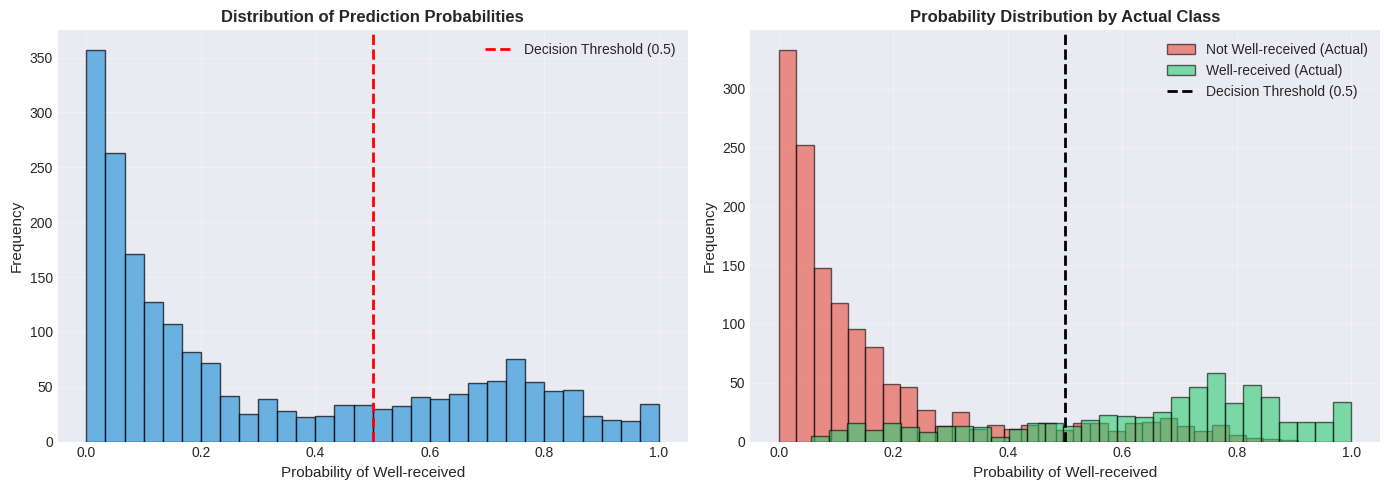

In [ ]:
# Visualize prediction probabilities distribution

# Extract probabilities (sample for plotting)
sample_size = min(2000, predictions.count())
predictions_sample = predictions.select("is_well_received", "prediction", "probability").sample(
    False, sample_size/predictions.count(), seed=42
).toPandas()

# Extract probability of class 1 (well-received)
prob_class1 = predictions_sample['probability'].apply(lambda x: x[1] if isinstance(x, (list, np.ndarray)) else float(x[1]))
predictions_sample['prob_well_received'] = prob_class1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of probabilities
axes[0].hist(predictions_sample['prob_well_received'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Probability of Well-received', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Prediction Probabilities', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Probability distribution by actual class
well_received_probs = predictions_sample[predictions_sample['is_well_received'] == 1]['prob_well_received']
not_well_received_probs = predictions_sample[predictions_sample['is_well_received'] == 0]['prob_well_received']

axes[1].hist(not_well_received_probs, bins=30, alpha=0.6, label='Not Well-received (Actual)', 
             color='#e74c3c', edgecolor='black')
axes[1].hist(well_received_probs, bins=30, alpha=0.6, label='Well-received (Actual)', 
             color='#2ecc71', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[1].set_xlabel('Probability of Well-received', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Probability Distribution by Actual Class', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



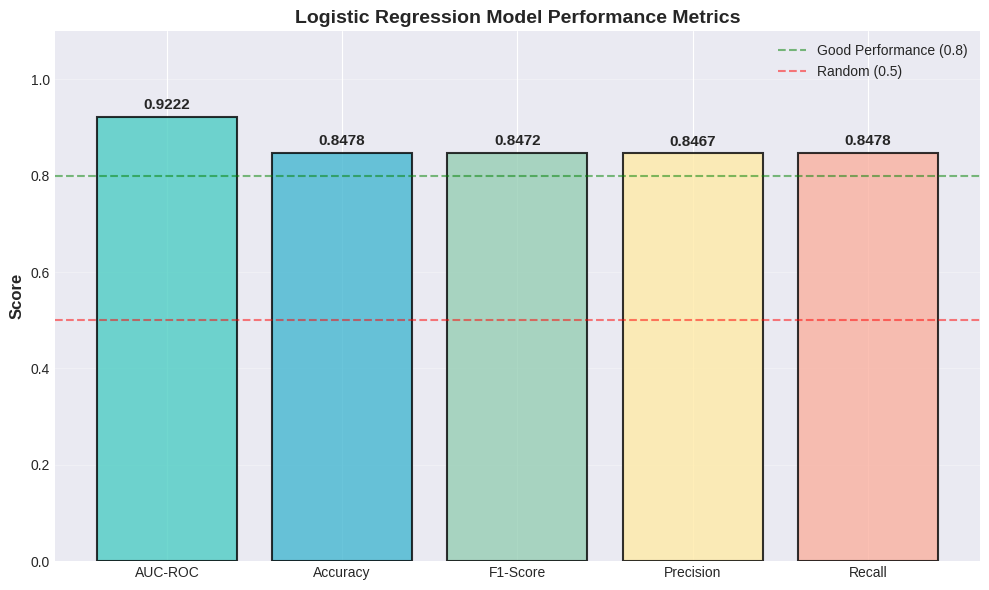

In [95]:
# Visualize model evaluation metrics

# Create metrics visualization
metrics = {
    'AUC-ROC': auc,
    'Accuracy': accuracy,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics.keys(), metrics.values(), color=['#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#fab1a0'], 
              alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, (metric, value) in zip(bars, metrics.items()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good Performance (0.8)')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (0.5)')
ax.legend()

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Step 7: Feature Importance (Logistic Regression Coefficients)


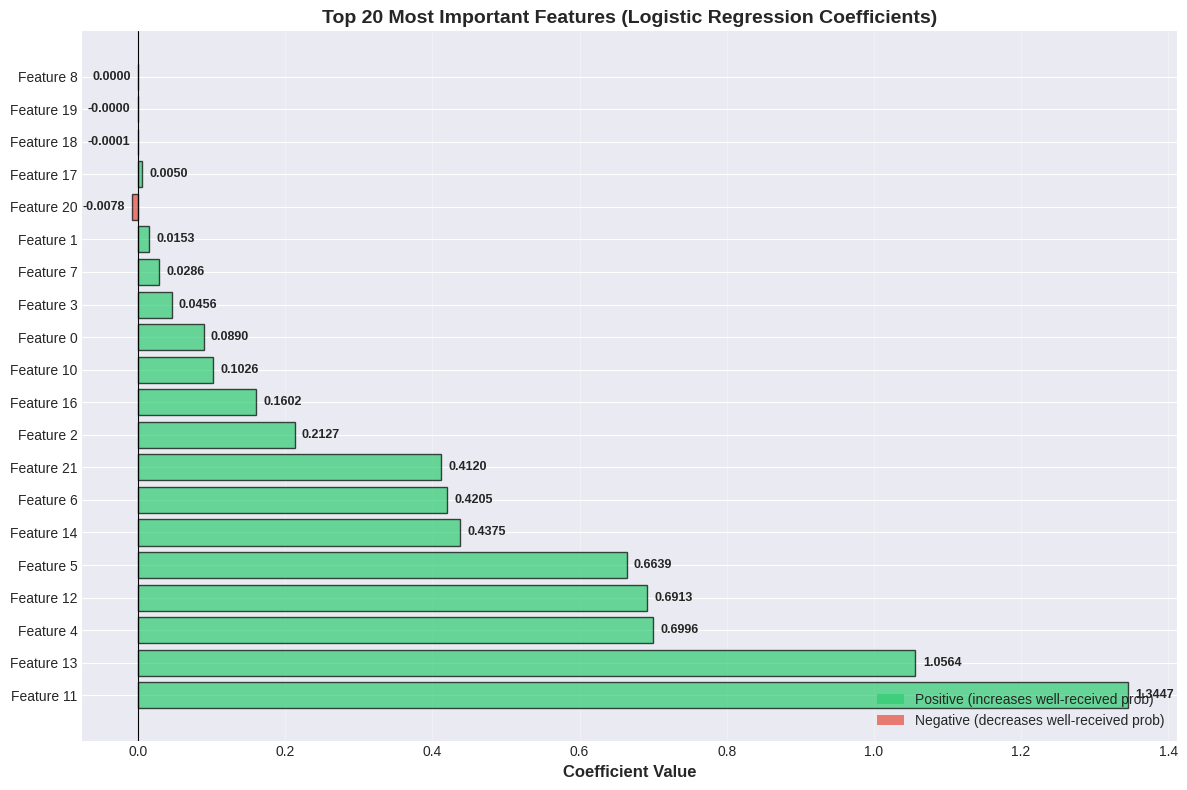

In [ ]:

# Visualize feature coefficients

# Get most important features
top_n = 20
top_coefficients = coefficient_importance[:top_n]

# Extract data for plotting
feature_indices = [idx for idx, _ in top_coefficients]
coef_values = [coef for _, coef in top_coefficients]
colors_coef = ['#2ecc71' if c > 0 else '#e74c3c' for c in coef_values]

fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
y_pos = np.arange(len(feature_indices))
bars = ax.barh(y_pos, coef_values, color=colors_coef, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, coef_values)):
    ax.text(val + (0.01 if val > 0 else -0.01), bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', ha='left' if val > 0 else 'right', va='center', 
            fontweight='bold', fontsize=9)

ax.set_yticks(y_pos)
ax.set_yticklabels([f'Feature {idx}' for idx in feature_indices])
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features (Logistic Regression Coefficients)', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', alpha=0.7, label='Positive (increases well-received prob)'),
                   Patch(facecolor='#e74c3c', alpha=0.7, label='Negative (decreases well-received prob)')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()




## Step 8: Detailed Evaluation Metrics


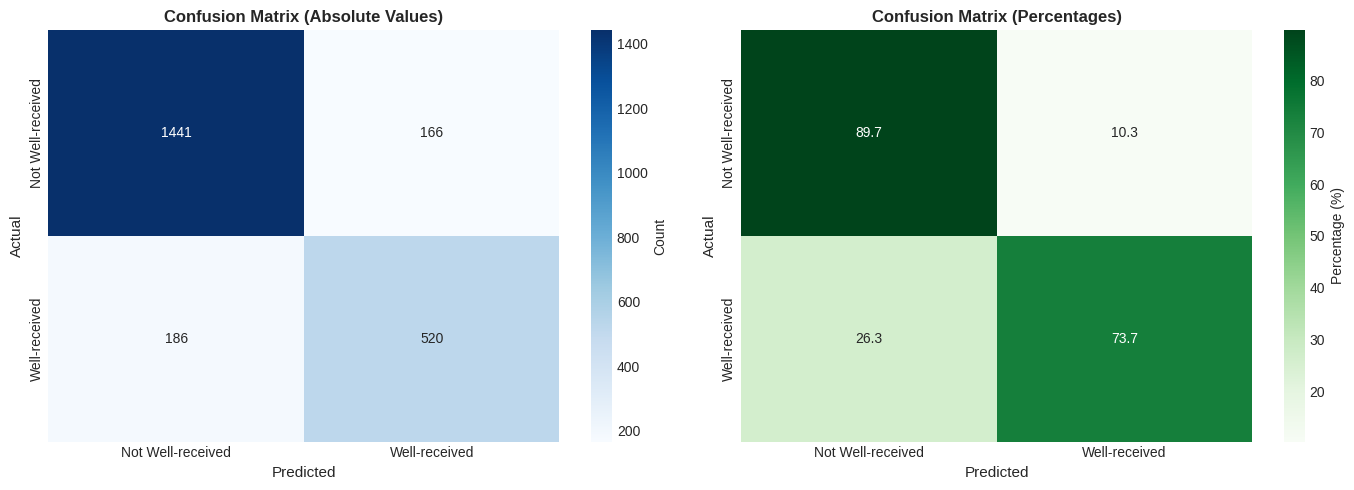

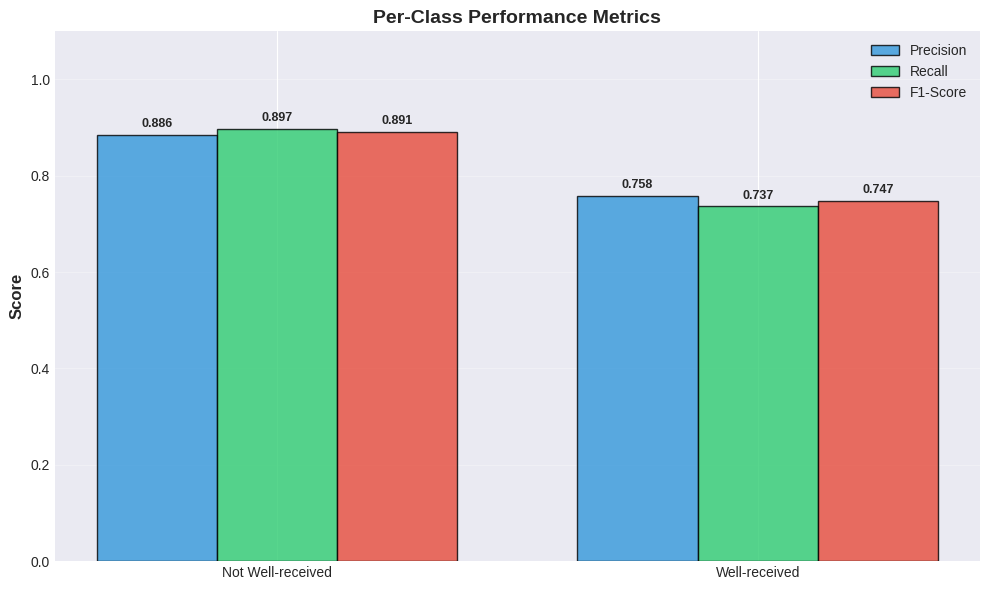

In [102]:
# Visualize confusion matrix

# Create confusion matrix heatmap
cm_array = np.array([[tn, fp], [fn, tp]])
cm_percent = cm_array / cm_array.sum(axis=1, keepdims=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute values heatmap
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Well-received', 'Well-received'],
            yticklabels=['Not Well-received', 'Well-received'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Absolute Values)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)

# Percentage heatmap
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=['Not Well-received', 'Well-received'],
            yticklabels=['Not Well-received', 'Well-received'],
            cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.show()

# Per-class metrics visualization
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Not Well-received', 'Well-received']
precision_scores = [precision_0, precision_1]
recall_scores = [recall_0, recall_1]
f1_scores = [f1_0, f1_1]

x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, precision_scores, width, label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, recall_scores, width, label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='#e74c3c', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Step 9: Analyze Misclassifications


In [109]:
# Analyze misclassified examples

# Find false positives
print("\nFalse Positives (Predicted: Well-received, Actual: Not well-received):")

false_positives = predictions.filter(
    (col("is_well_received") == 0) & (col("prediction") == 1.0)
).select("name", "pct_pos_total", "num_reviews_total", "weighted_score", "probability")

false_positives.show(10, truncate=False)
print(f"\nTotal false positives: {false_positives.count()}")

# Find false negatives

print("False Negatives (Predicted: Not well-received, Actual: Well-received):")

false_negatives = predictions.filter(
    (col("is_well_received") == 1) & (col("prediction") == 0.0)
).select("name", "pct_pos_total", "num_reviews_total", "weighted_score", "probability")

false_negatives.show(10, truncate=False)
print(f"\nTotal false negatives: {false_negatives.count()}")



False Positives (Predicted: Well-received, Actual: Not well-received):
+------------------------------------------+-------------+-----------------+------------------+----------------------------------------+
|name                                      |pct_pos_total|num_reviews_total|weighted_score    |probability                             |
+------------------------------------------+-------------+-----------------+------------------+----------------------------------------+
|Soldiers: Heroes of World War II          |84           |690              |2.3851615597943265|[0.49149273510254243,0.5085072648974576]|
|Vector                                    |90           |965              |2.6864794137739443|[0.39401141859922006,0.6059885814007799]|
|Home Sheep Home: Farmageddon Party Edition|94           |355              |2.3983629980945027|[0.2958756328635303,0.7041243671364696] |
|Suicide Guy                               |87           |2088             |2.8883464427828685|[0.35348698

## Step 10: Save Model (Optional)


In [110]:
# Save the Logistic Regression model
model_output_path = "models/game_success_lr_model"

lr_model.write().overwrite().save(model_output_path)


## Summary


### Classification Task:
- **Target**: Predict if a game is "well-received" (binary classification)
- **Weighted Score Formula**: `(pct_pos_total / 100.0) × log10(num_reviews_total + 1)`
- **Threshold**: 70th percentile weighted score (top 30% are well-received)

### Model Trained:
- **Logistic Regression**: Fast, interpretable model with coefficient analysis

### Evaluation Metrics:
- **AUC-ROC**: Area under ROC curve (measures model's ability to distinguish classes)
- **Accuracy**: Overall classification accuracy
- **F1-Score**: Harmonic mean of precision and recall
- **Precision & Recall**: Per-class metrics
- **Confusion Matrix**: Detailed per-class performance

### Key Findings:
- Model coefficients show which features are most important
- Misclassification analysis helps understand model limitations
- Feature importance can guide feature engineering improvements


In [ ]:
spark.stop()

Spark session stopped.
